In [1]:
import os
import numpy as np
from qiskit import*
import qiskit
from qiskit import transpile,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import Aer
from qiskit.quantum_info import partial_trace
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.quantum_info import DensityMatrix
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, kron
large = 40; med = 40; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)

In [2]:
def partial_trace_4_4(matrix):
        return np.matrix([[matrix[0,0]+matrix[1,1], matrix[0,2]+matrix[1,3]],
                          [matrix[0,2]+matrix[3,1], matrix[2,2]+matrix[3,3]]])

I2 = np.array([[1,0],[0,1]])
sigma_x =np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

PI_0 = np.matrix([[1,0],[0,0]])
PI_1 = np.matrix([[0,0],[0,1]])                          

def controlled_ry_gate_matrix(angle_theta):

        def ry_matrix(angle):
                return np.matrix([[np.cos(angle/2),-np.sin(angle/2)],
                                  [np.sin(angle/2),np.cos(angle/2)]])
        return kron(PI_0,I2) + kron(PI_1,ry_matrix(angle_theta))

def controlled_not_gate_matrix():
        return kron(I2,PI_0) + kron(sigma_x,PI_1)

gamma_in = 2.6
gamma_out = 2.6

#### Hamiltonian of $H_{2}$ with Jordan Wigner transformation

In [3]:
# H2 molecule after Jordan Wigner transformation
L = 4
H_pauli_lst = ['IIII','IIIZ', 'IIZI', 'IIZZ', 'IZII',
               'IZIZ', 'ZIII', 'ZIIZ','YYYY', 'XXYY', 'YYXX', 'XXXX','IZZI', 'ZIZI', 'ZZII']
H_pauli_coeff_lst = [-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j]


def sparse_Pauli_to_dense_matrix(sparse_Pauli_matrices_lst, Pauli_matrices_coefficients):
    
    # Pauli matrices dictionary
    pauli_matrices_dict = {"I": np.array([[1,0],
                                          [0,1]]),
                  "X": np.array([[0,1],
                                 [1,0]]),
                  "Y": np.array([[0,-1j],
                                 [1j,0]]),
                  "Z": np.array([[1,0],
                                 [0,-1]])}
    
    sparse_pauli_matrices_dict = {key: csr_matrix(value) for key, value in pauli_matrices_dict.items()}      

    sparse_hamiltonian = csr_matrix((2**L, 2**L))

    # converts a pauli string into a matrix
    def pauli_string_to_matrix(pauli_string):
        mat = sparse_pauli_matrices_dict[pauli_string[0]]
        """for p_string in range(L-2,-1,-1):
          mat = kron(sparse_pauli_matrices_dict[pauli_string[p_string]],mat)
        return mat"""
        for p_string in range(1,L):
           mat = kron(mat,sparse_pauli_matrices_dict[pauli_string[p_string]])
        return mat
    
    for i in range(len(sparse_Pauli_matrices_lst)):
      
      sparse_hamiltonian += Pauli_matrices_coefficients[i] * pauli_string_to_matrix(sparse_Pauli_matrices_lst[i])
      
    return sparse_hamiltonian

full_hamiltonian = sparse_Pauli_to_dense_matrix(H_pauli_lst,H_pauli_coeff_lst);

#### $n=1$ and $n=2$ states of the Hamiltonian

In [4]:
"""# n = 1 basis states 0001,0010,0100,1000
def ket_from_binary_string(binary_string):
        bin_dict = {"0":np.matrix([1,0]), "1":np.matrix([0,1])}
        b_0 = bin_dict[binary_string[-1]]
        for b in range(len(binary_string)-2,-1,-1):
                b_0 = kron(bin_dict[binary_string[b]],b_0)
        return b_0

n_1_sector_basis_states = [ket_from_binary_string("0001"),ket_from_binary_string("0010"),ket_from_binary_string("0100"),
                           ket_from_binary_string("1000")]

n_1_sector_size = 4
H_n_1_sector = np.zeros((n_1_sector_size,n_1_sector_size),dtype=np.complex128)

for m in range(len(n_1_sector_basis_states)):
        for n in range(len(n_1_sector_basis_states)):
                ket_m = n_1_sector_basis_states[m]
                ket_n = n_1_sector_basis_states[n]
                H_n_1_sector[m,n] = (ket_m *full_hamiltonian* ket_n.T).A[0,0]


# n = 2 basis states 0011,0101,0110,1001,1010,1100
n_2_sector_basis_states = [ket_from_binary_string("0011"),ket_from_binary_string("0101"),ket_from_binary_string("0110"),
                           ket_from_binary_string("1001"),ket_from_binary_string("1010"),
                           ket_from_binary_string("1100")]

n_2_sector_size = 6
H_n_2_sector = np.zeros((n_2_sector_size,n_2_sector_size),dtype=np.complex128)

for m in range(len(n_2_sector_basis_states)):
        for n in range(len(n_2_sector_basis_states)):
                ket_m = n_2_sector_basis_states[m]
                ket_n = n_2_sector_basis_states[n]
                H_n_2_sector[m,n] = (ket_m *full_hamiltonian* ket_n.T).A[0,0]""";

In [5]:
#n_2_eigvals, n_2_eigstates = np.linalg.eigh(H_n_2_sector)

In [6]:
#n_1_eigvals, n_1_eigstates = np.linalg.eigh(H_n_1_sector)

#### One time step circuit for trotterization

In [7]:
#L = 4
def one_time_step_circuit(dt,barrier_status):

    def ZZ_gate_circuit(qubit_2, qubit_1, coefficient, delta_t): # count qubits from right as in Qiskit
        qc_zz = QuantumCircuit(L)
        qc_zz.cx(qubit_1,qubit_2)
        qc_zz.rz(2*coefficient*delta_t, qubit_2)
        qc_zz.cx(qubit_1,qubit_2)
        return qc_zz
    
    # Existing quantum registers
    qr = QuantumRegister(L,"q")
    anc = QuantumRegister(1,r"\rm{ancilla}")


    # Create a new quantum circuit with the classical register
    qc_h2 = QuantumCircuit(anc,qr)    


    # one Z gate 
    # 1,2,4,6
    qc_h2.rz(2*H_pauli_coeff_lst[1].real*dt,qr[0])
    qc_h2.rz(2*H_pauli_coeff_lst[2].real*dt,qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[4].real*dt,qr[2])
    qc_h2.rz(2*H_pauli_coeff_lst[6].real*dt,qr[3])
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # two z gates
    # 3,5,7,12,13,14

    # IIZZ 3
    #qc_h2 = qc_h2.compose(ZZ_gate_circuit(qr[1],qr[0],H_pauli_coeff_lst[3].real,dt))
    qc_h2.cx(qr[0],qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[3].real*dt,qr[1])
    qc_h2.cx(qr[0],qr[1])
    # ZZII 14
    #qc_h2 = qc_h2.compose(ZZ_gate_circuit(qr[3],qr[2],H_pauli_coeff_lst[14].real,dt))     
    qc_h2.cx(qr[2],qr[3])
    qc_h2.rz(2*H_pauli_coeff_lst[14].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])   

    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # IZIZ 5
    qc_h2.swap(qr[1],qr[2])
    #qc_h2 = qc_h2.compose(ZZ_gate_circuit(qr[1],qr[0],H_pauli_coeff_lst[5].real,dt))
    qc_h2.cx(qr[0],qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[5].real*dt,qr[1])
    qc_h2.cx(qr[0],qr[1])    
    qc_h2.swap(qr[1],qr[2])    
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # ZIZI 13
    qc_h2.swap(qr[1],qr[2])
    #qc_h2 = qc_h2.compose(ZZ_gate_circuit(qr[3],qr[2],H_pauli_coeff_lst[13].real,dt))
    qc_h2.cx(qr[2],qr[3])
    qc_h2.rz(2*H_pauli_coeff_lst[13].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])     
    qc_h2.swap(qr[1],qr[2])
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # ZIIZ 7 
    qc_h2.swap(qr[3],qr[2])
    qc_h2.swap(qr[2],qr[1])        
    #qc_h2 = qc_h2.compose(ZZ_gate_circuit(qr[1],qr[0],H_pauli_coeff_lst[7].real,dt))
    qc_h2.cx(qr[0],qr[1])
    qc_h2.rz(2*H_pauli_coeff_lst[7].real*dt,qr[1])
    qc_h2.cx(qr[0],qr[1])     
    qc_h2.swap(qr[2],qr[1])       
    qc_h2.swap(qr[3],qr[2])        
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass
    # IZZI 12
    #qc_h2 = qc_h2.compose(ZZ_gate_circuit(qr[2],qr[1],H_pauli_coeff_lst[12].real,dt))    
    qc_h2.cx(qr[1],qr[2])
    qc_h2.rz(2*H_pauli_coeff_lst[12].real*dt,qr[2])
    qc_h2.cx(qr[1],qr[2])
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # XXXX 
    for i in range(L):
        qc_h2.h(qr[i])

    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[11].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])

    for i in range(L):
        qc_h2.h(qr[i])   
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass   

    # YYYY
    for i in range(L):
        qc_h2.sdg(qr[i])    
    for i in range(L):
        qc_h2.h(qr[i])       
    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx([1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[8].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])
    for i in range(L):
        qc_h2.h(qr[i])  
    for i in range(L):
        qc_h2.sdg(qr[i])  
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass   

    # XXYY
    qc_h2.sdg(qr[0])
    qc_h2.h(qr[0])
    qc_h2.sdg(qr[1])
    qc_h2.h(qr[1])   
    qc_h2.h(qr[2])
    qc_h2.h(qr[3])

    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[9].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])   

    qc_h2.h(qr[0])
    qc_h2.sdg(qr[0])
    qc_h2.h(qr[1]) 
    qc_h2.sdg(qr[1])  
    qc_h2.h(qr[2])
    qc_h2.h(qr[3])     
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass

    # YYXX
    qc_h2.sdg(qr[2])
    qc_h2.h(qr[2])
    qc_h2.sdg(qr[3])
    qc_h2.h(qr[3])   
    qc_h2.h(qr[0])
    qc_h2.h(qr[1])    
    qc_h2.cx(qr[0],qr[1])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[2],qr[3])    
    qc_h2.rz(2*H_pauli_coeff_lst[10].real*dt,qr[3])
    qc_h2.cx(qr[2],qr[3])
    qc_h2.cx(qr[1],qr[2])
    qc_h2.cx(qr[0],qr[1])
    qc_h2.h(qr[2])  
    qc_h2.sdg(qr[2])
    qc_h2.h(qr[3])   
    qc_h2.sdg(qr[3])
    qc_h2.h(qr[0])
    qc_h2.h(qr[1])

    qc_h2.barrier()

    # ancilla qubit

    # L_out
    theta_out = 2*np.arcsin(np.sqrt(dt*gamma_out))
    qc_h2.initialize([1,0],anc[0])
    qc_h2.cry(theta_out,qr[0],anc)
    qc_h2.cx(anc,qr[0])
    qc_h2.initialize([1,0],anc)    
    if barrier_status == True:
        qc_h2.barrier()
    else:
        pass        
    # L_in
    qc_h2.x(qr[0])
    theta_in = 2*np.arcsin(np.sqrt(dt*gamma_in))
    qc_h2.cry(theta_in,qr[0],anc)
    qc_h2.cx(anc,qr[0])
    qc_h2.x(qr[0])
    qc_h2.initialize([1,0],anc)
    return qc_h2
#one_time_step_circuit(0.1,True).draw("mpl",style="iqp",scale=2)#.savefig("H2_Lindbladian_circuit_not_optimized.jpg",dpi=200)

#### Complete trotter circuit for time evolution

In [8]:
def time_evolved_density_matrix(time_step,final_time,initial_state):
    number_of_iterations = int(final_time/time_step)
    #print("Number of Floquet cycles = ", number_of_iterations)
    transpiled_one_step_circuit = transpile(one_time_step_circuit(time_step,False), basis_gates = ["rz","cx","h",], optimization_level=2)

    # Existing quantum registers
    qr = QuantumRegister(L,"q")
    anc = QuantumRegister(1,"ancilla")

    # Add a classical register
    cr = ClassicalRegister(L,"c")
    # Create a new quantum circuit with the classical register
    qc = QuantumCircuit(anc,qr, cr)

    # system is initialized at the user defined state
    qubit_dict = {"1":[0,1],"0":[1,0]}

    r"""
        The initial state is assigned in reverse order because of qiskit's convention
        of counting from right to left. So the first value of the initial state string
        is assigned to the bottom qubit and the last value of the initial state string
        is assigned to the top qubit!
    """
    #qc.initialize(qubit_dict[initial_state[3]],qr[0])
    #qc.initialize(qubit_dict[initial_state[2]],qr[1])
    #qc.initialize(qubit_dict[initial_state[1]],qr[2])
    #qc.initialize(qubit_dict[initial_state[0]],qr[3])

    for _ in range(number_of_iterations):
        qc = qc.compose(transpiled_one_step_circuit)
    """qc.measure(anc,cr[4])
    qc.measure(qr[3], cr[3])   
    qc.measure(qr[2], cr[2])
    qc.measure(qr[1], cr[1])
    qc.measure(qr[0], cr[0])"""

    #print("Circuit depth = ",qc.depth())
    #qc.measure_all()
    return qc
#time_evolved_density_matrix(0.1,0.1,"0100").draw("mpl",style="iqp",scale=2)

#### $I_{\rm in}$ in terms of Pauli operators

In [9]:
def pauli_product(pauli_i,pauli_j):

        I2 = np.array([[1,0],[0,1]])
        sigma_x =np.array([[0,1],[1,0]])
        sigma_y = np.array([[0,-1j],[1j,0]])
        sigma_z = np.array([[1,0],[0,-1]])

        pauli_matrices_dict = {"I":I2, "X":sigma_x, "Y": sigma_y, "Z": sigma_z}

        pauli_product = pauli_matrices_dict[pauli_i]@pauli_matrices_dict[pauli_j]

        b_0 = np.trace(I2@pauli_product)/2
        b_x = np.trace(sigma_x@pauli_product)/2
        b_y = np.trace(sigma_y@pauli_product)/2
        b_z = np.trace(sigma_z@pauli_product)/2

        pauli_list = np.array(["I","X","Y","Z"])
        coeff_lst = np.array([b_0,b_x,b_y,b_z])

        non_zero_coeff = np.nonzero(coeff_lst)

        return coeff_lst[non_zero_coeff][0],pauli_list[non_zero_coeff][0]

def hamiltonian_product_pauli(original_hamiltonian_pauli_lst, original_hamiltonian_pauli_coeff, pauli_matrix_to_multiply, action_direction):

        new_hamiltonian_pauli_lst = []
        new_hamiltonian_pauli_coeff = []        
        if action_direction == "left":
                for i in range(len(original_hamiltonian_pauli_lst)):

                        pauli_strings = original_hamiltonian_pauli_lst[i]
                        pauli_coeff  = original_hamiltonian_pauli_coeff[i]

                        operator_on_qubit_0 = pauli_strings[-1]

                        # pauli matrix multiplied from left
                        qubit_0_pauli_product = pauli_product(pauli_matrix_to_multiply,operator_on_qubit_0)
                        new_hamiltonian_pauli_lst.append(pauli_strings[0:L-1]+qubit_0_pauli_product[1])
                        new_hamiltonian_pauli_coeff.append(pauli_coeff*qubit_0_pauli_product[0])

        elif action_direction == "right":
                for i in range(len(original_hamiltonian_pauli_lst)):

                        pauli_strings = original_hamiltonian_pauli_lst[i]
                        pauli_coeff  = original_hamiltonian_pauli_coeff[i]

                        operator_on_qubit_0 = pauli_strings[-1]

                        # pauli matrix multiplied from right
                        qubit_0_pauli_product = pauli_product(operator_on_qubit_0,pauli_matrix_to_multiply)
                        new_hamiltonian_pauli_lst.append(pauli_strings[0:L-1]+qubit_0_pauli_product[1])
                        new_hamiltonian_pauli_coeff.append(pauli_coeff*qubit_0_pauli_product[0])

        return new_hamiltonian_pauli_lst, new_hamiltonian_pauli_coeff              

def add_similar_elements(pair1, pair2):

    dict1 = dict(zip(pair1[0], pair1[1]))
    dict2 = dict(zip(pair2[0], pair2[1]))

    all_keys = set(dict1.keys()).union(set(dict2.keys()))

    result_dict = {key: dict1.get(key, 0) + dict2.get(key, 0) for key in all_keys}

    result_pair = (list(result_dict.keys()), list(result_dict.values()))

    return result_pair 

#L_1 = III(X-1j*Y)/2
def L_1_dag_H_L_1():
        # L_1_dag H L_1 = (X+1j*Y)/2 = XHX-1j*XHY+1j*YHX+YHY

        # XHX
        # X from left
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left")
        # X from right
        h2, p2 = hamiltonian_product_pauli(h1,p1,"X","right") # XHX

        # XHY
        h3,p3 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"X","left")
        h4,p4 = hamiltonian_product_pauli(h3,p3,"Y","right")  # XHY

        # YHX
        h5,p5 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left")
        h6,p6 = hamiltonian_product_pauli(h5,p5,"X","right")  # YHX

        # YHY
        h7,p7 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Y","left")
        h8,p8 = hamiltonian_product_pauli(h7,p7,"Y","right")  # YHY

        h_iter_1, p_iter_1 = add_similar_elements((h2,np.array(p2)),(h4,-1j*np.array(p4)))
        h_iter_2, p_iter_2 = add_similar_elements((h_iter_1,p_iter_1),(h6,1j*np.array(p6)))
        h_iter_3, p_iter_3 = add_similar_elements((h_iter_2,p_iter_2),(h8,np.array(p8)))
        return h_iter_3, p_iter_3

def H_L1_dag_L1():
        # H L1_dag L_1 = (1/2)*HI - (1/2)*HZ

        # H*I
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"I","right")
        # HZ
        h2,p2 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Z","right")
        return add_similar_elements((h1,(1/2)*np.array(p1)),(h2,-(1/2)*np.array(p2)))

def L_1_dag_L_1_H():
        # L1_dag L_1 H = (1/2)*IH - (1/2)*ZH

        # H*I
        h1,p1 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"I","left")
        # HZ
        h2,p2 = hamiltonian_product_pauli(H_pauli_lst,H_pauli_coeff_lst,"Z","left")
        return add_similar_elements((h1,(1/2)*np.array(p1)),(h2,-(1/2)*np.array(p2)))        
# L_2 = III(X+1j*Y)/2 
#add_similar_elements((h1,np.array(p1)),(H_pauli_lst,np.array(H_pauli_coeff_lst)))
I_in_term_1_term_2 = add_similar_elements((L_1_dag_H_L_1()[0],L_1_dag_H_L_1()[1]),(H_L1_dag_L1()[0],H_L1_dag_L1()[1]))
I_in_term_1_term_2_term_3 = add_similar_elements((I_in_term_1_term_2[0],I_in_term_1_term_2[1]),(L_1_dag_L_1_H()[0],L_1_dag_L_1_H()[1]))

#### Noise model for the simulator

In [10]:
T1_noise = 213.07e3
T2_noise = 115.57e3

T1_standard_deviation = T1_noise/4
T2_standard_deviation = T2_noise/4

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(T1_noise, T1_standard_deviation, L+1) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(T2_noise, T2_standard_deviation, L+1)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(L+1)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_sx = 100
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_sx  = [thermal_relaxation_error(t1, t2, time_sx)
              for t1, t2 in zip(T1s, T2s)]              
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]
errors_ecr = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]               

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(L+1):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_sx[j], "sx",[j])
    noise_thermal.add_quantum_error(errors_sx[j], "rz",[j])
    #noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    #noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    #noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(L+1):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        noise_thermal.add_quantum_error(errors_ecr[j][k], "ecr", [j, k])   
print(noise_thermal)    

NoiseModel:
  Basis gates: ['cx', 'ecr', 'id', 'rz', 'sx']
  Instructions with noise: ['sx', 'rz', 'cx', 'ecr', 'measure', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('rz', (0,)), ('rz', (1,)), ('rz', (2,)), ('rz', (3,)), ('rz', (4,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (2, 4)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3)), ('cx', (3, 4)), ('cx', (4, 0)), ('cx', (4, 1)), ('cx', (4, 2)), ('cx', (4, 3)), ('cx', (4, 4)), ('ecr', (0, 0)), ('ecr', (0, 1)), ('ecr', (0, 2)), ('ecr', (0, 3)), ('ecr', (0, 4)), 

#### Trotterization of the system

In [11]:
r"""

 This function appends a H gate for X measurement and S_{\dagger}*H gate for Y measurement.

"""

def measure_observables_circuit(observable_string):
    # Existing quantum registers
    qr = QuantumRegister(L,"q")
    anc = QuantumRegister(1,"ancilla")

    # Add a classical register
    cr = ClassicalRegister(L,"c")
    
    # Create a new quantum circuit with the classical register
    qc_basis_change = QuantumCircuit(anc,qr, cr)

    observable_string = observable_string[::-1]
    
    for i in range(L):
        if observable_string[i] == "I":
            pass
        elif observable_string[i] == "Z":
            pass
        elif observable_string[i] == "X":
            qc_basis_change.h(i+1)
        elif observable_string[i] == "Y":
            qc_basis_change.sdg(i+1)
            qc_basis_change.h(i+1)
    #qc_basis_change.measure(anc,cr[4])
    qc_basis_change.measure(qr[3], cr[3])   
    qc_basis_change.measure(qr[2], cr[2])
    qc_basis_change.measure(qr[1], cr[1])
    qc_basis_change.measure(qr[0], cr[0])              
    return qc_basis_change
#measure_observables_circuit(I_in_term_1_term_2_term_3[0][7]).draw("mpl", style= "iqp",scale=1)

In [12]:
def trotter_simulation_and_return_counts(pauli_string_to_calculate_expectation_value,
                                         time_step_for_trotterization,
                                         initial_state_of_system,
                                         t_final,
                                         number_of_shots,
                                         ):
        # constructs the trotter circuit and prepares the density matrix
        trotter_circuit = time_evolved_density_matrix(time_step_for_trotterization,t_final,initial_state_of_system)

        # composes necessary basis change to measures pauli operators X and Y if exists in pauli string
        trotter_circuit = trotter_circuit.compose(measure_observables_circuit(pauli_string_to_calculate_expectation_value))

        sim_thermal = AerSimulator(noise_model=noise_thermal)

        basis_set_2 = ["ecr","id","rz","sx","x"]
        transpiled_trotter_circuit = transpile(trotter_circuit, sim_thermal, basis_gates = basis_set_2 ,optimization_level = 2)

        result_thermal = sim_thermal.run(transpiled_trotter_circuit, shots = number_of_shots).result()

        counts_thermal = result_thermal.get_counts()

        return counts_thermal

In [13]:
r"""

This function takes a string as input and return its components. For example,
input: "XXYZ"
output: "XIII" "IXII" "IIYI" "IIIZ"

"""
def pauli_string_components(pauli_string):

        pauli_string_decomposed = []
        for i in range(len(pauli_string)):
                pauli_string_element = pauli_string[i]
                # number of pauli element on left
                left_string_length = i
                # number of pauli element on right
                right_string_length = len(pauli_string) - i - 1
                pauli_string_decomposed.append([left_string_length,pauli_string_element,right_string_length])

        string_components = []
        for i in pauli_string_decomposed:
                string_components.append("I"*i[0] + i[1] + "I"*i[2])
        return string_components     
        
r"""

This function calculates the takes a binary string and bit positions (list) as input
and return the product of {-1,1} depending on whether there is 0 (+1) or 1 (-1) in that position.
For example, input: ["0000", "0001", "0010",.....,"1111"] and [1,3]
            output: [1,1,-1,.....,1]

"""
def calculate_products(binary_list, bit_positions):
    products = []
    for binary_str in binary_list:
        product = 1
        for pos in bit_positions:
            bit = int(binary_str[-(pos+1)])  # Counting the rightmost bit as 0th bit
            product *= 1 if bit == 0 else -1
        products.append(product)
    return np.array(products)


r"""

This function returns the expectation value of a pauli string.
input: "XXYX" (for example) output: expectation value of "XXYX"

"""
def expectation_value_of_a_pauli_string(pauli_string,
                                        observable_counts_dict_sorted):
        # decomposing the pauli strings
        pauli_string_decomposed_lst = pauli_string_components(pauli_string)

        products_array = np.ones((L,2**L)) # list to hold the products of bits as -1 or 1
        probability_array = np.ones((L,2**L)) 

        number_of_shots = 8192
        
        # iterating over each element in the decomposition of the pauli string
        for i in range(len(pauli_string_decomposed_lst)):

                decomposed_string = pauli_string_decomposed_lst[i]

                if decomposed_string == "IIII":
                        pass
                else:
                        # string other than "IIII"
                        bit_strings_and_counts = list(observable_counts_dict_sorted[decomposed_string].items()) # result from simulation
                        for j in range(2**L): # iterating over all binary strings with L bits
                                binary_string = bit_strings_and_counts[j][0]
                                bit = binary_string[i] # i th position in the binary string is not "I"
                                if bit == "0":
                                        products_array[i,j] *= 1
                                elif bit == "1":
                                        products_array[i,j] *= -1
                                probability_array[i,j] = bit_strings_and_counts[j][1]/number_of_shots

        return np.sum(np.prod(products_array*probability_array, axis = 0))
#expectation_value_of_a_pauli_string("YYYY")        

In [18]:
def single_pauli_expectation_value(time):

        r"""
        
        The expectation value of the following list of pauli strings will be calculated.
        
        """
        single_pauli_strings_lst = ["IIIX","IIXI","IXII","XIII",
                                     "IIIY","IIYI","IYII","YIII",
                                     "IIIZ","IIZI","IZII","ZIII"]
        number_of_shots = 8192
        time_step_for_trotterization = 0.1
        initial_state_of_system = "0100"

        observable_counts_dict = {}

        for i in range(len(single_pauli_strings_lst)):

                pauli_string = single_pauli_strings_lst[i]

                sim_counts = trotter_simulation_and_return_counts(pauli_string,
                                                time_step_for_trotterization,
                                                initial_state_of_system,
                                                time,
                                                number_of_shots,
                                                )

                observable_counts_dict[pauli_string] = sim_counts

        # sorts the dictionary of counts such that it starts with "0000" and ends with "1111"
        observable_counts_dict_sorted = {}
        for pauli_strings in observable_counts_dict:
                d = observable_counts_dict[pauli_strings]
                sorted_d = {k: d[k] for k in sorted(d, key=lambda x: int(x, 2))}
                observable_counts_dict_sorted[pauli_strings] = sorted_d
        return observable_counts_dict_sorted       

time_lst = np.linspace(0.1,20,10)

"""for time in time_lst:        
        t = single_pauli_expectation_value(time)
        os.chdir("/Users/sasankadowarah/Ultimate_QM_MM/current_data_folder")
        np.save("t_"+str(np.around(time,2))+".npy",t)""";

In [19]:
I_in_pauli_list = I_in_term_1_term_2_term_3[0]
I_in_coefficients = I_in_term_1_term_2_term_3[1]
if "IIII" in I_in_pauli_list:
    index = I_in_pauli_list.index("IIII")
    I_in_pauli_list.pop(index)
    I_in_coefficients.pop(index)

In [45]:
# loads the data from file
os.chdir("/Users/sasankadowarah/Ultimate_QM_MM/current_data_folder")
I_in_expectation_value_array = np.array([])
for time in time_lst:
        t_load = np.load("t_"+str(np.around(time,2))+".npy",allow_pickle=True)
        t_load_dict = t_load.item()

        I_in_expectation_value = 0
        for i in range(len(I_in_pauli_list)): # avoiding the element "IIII"
                pauli_string = I_in_pauli_list[i]
                coefficients = I_in_coefficients[i]
                I_in_expectation_value += coefficients * expectation_value_of_a_pauli_string(pauli_string, t_load_dict)
        I_in_expectation_value_array = np.append(I_in_expectation_value_array,I_in_expectation_value)  

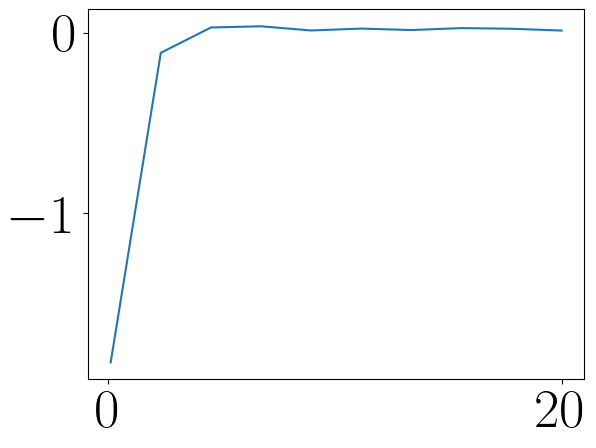

In [48]:
plt.plot(time_lst,I_in_expectation_value_array.real)
plt.show()

In [ ]:
time_step_for_trotterization = 0.1
initial_state_of_system = "0100"
time_lst = np.linspace(time_step_for_trotterization,10,10)
counts_lst = []
density_matrices_lst = []

#sim_thermal = Aer.get_backend("qasm_simulator")
sim_thermal = AerSimulator(noise_model=noise_thermal)

basis_set_1 = ["rz","cx","h"]
basis_set_2 = ["ecr","id","rz","sx","x"]

I_in_expectation_value = []
for time in time_lst:

        # contstructs the time evolved density matrix quantum circuit
        h_2_molecule_circuit = time_evolved_density_matrix(time_step_for_trotterization,time,initial_state_of_system)

        # measuring the obervables in I_in_term
        for i in range(len(I_in_term_1_term_2_term_3)):
                
                pauli_string = I_in_term_1_term_2_term_3[i]

                # basis change to measure the corresponding operator of the Hamiltonian
                h_2_molecule_circuit = h_2_molecule_circuit.compose(measure_observables_circuit(pauli_string))
                
                # transpile the circuit
                circ_tthermal = transpile(h_2_molecule_circuit, sim_thermal, basis_gates = basis_set_2 ,optimization_level = 2)

                # runs the circuit in the simulator
                result_thermal = sim_thermal.run(circ_tthermal, shots = 1000).result()

                #statevector = result.get_statevector()
                counts_thermal = result_thermal.get_counts()

                I_in_expectation_value.append(counts_thermal);                

#### $I_{\rm in}$

In [ ]:
I_in_pauli_lst = []
for i in range(len(I_in_term_1_term_2_term_3[0])):
        I_in_pauli_lst.append((I_in_term_1_term_2_term_3[0][i]+"I",I_in_term_1_term_2_term_3[1][i]))

In [ ]:
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
 
time_step_for_trotterization = 0.1
time = 0.2
initial_state_of_system = "0100"
basis_set_2 = ["ecr","id","rz","sx","x","reset"]

h_2_molecule_circuit = time_evolved_density_matrix(time_step_for_trotterization,time,initial_state_of_system+"0")
sim_thermal = AerSimulator(noise_model=noise_thermal)
circ_tthermal = transpile(h_2_molecule_circuit, sim_thermal,optimization_level = 2)
job = execute(h_2_molecule_circuit, sim_thermal, noise_model = noise_thermal)
#noisy_state = job.result().get_statevector()
I_in_expectation_value = []
for i in range(len(I_in_pauli_lst)):

        observable_term = SparsePauliOp.from_list([I_in_pauli_lst[i]])

        estimator = Estimator()
        expectation_value = estimator.run(circ_tthermal, observable_term).result().values.real
 
        I_in_expectation_value.append(expectation_value)

#### Current in and out plot

In [ ]:
I2 = np.matrix([[1,0],
                [0,1]])
sigma_x = np.matrix([[0,1],
                     [1,0]])
sigma_y = np.matrix([[0,-1j],
                     [1j,0]])
sigma_z = np.matrix([[1,0],
                     [0,-1]])

# sigma_- acting on the first qubit
L_in  = kron(I2,kron(I2,kron(I2,(sigma_x - 1j*sigma_y)/2)))
L_out = kron(I2,kron(I2,kron(I2,(sigma_x + 1j*sigma_y)/2)))

# energy currents definition
def I_in(hamiltonian, density_matrix):
        return gamma_in*np.trace((L_in.conj().T@hamiltonian@L_in
                - (1/2)*hamiltonian@L_in.conj().T@L_in
                - (1/2)*L_in.conj().T@L_in@hamiltonian)@density_matrix)

def I_out(hamiltonian, density_matrix):
        return gamma_out*np.trace((L_out.conj().T@hamiltonian@L_out
                - (1/2)*hamiltonian@L_out.conj().T@L_out
                - (1/2)*L_out.conj().T@L_out@hamiltonian)@density_matrix)

In [ ]:
I_in_lst = []
I_out_lst = []
for rho in density_matrices_lst:
        I_in_lst.append(I_in(full_hamiltonian,rho).real)
        I_out_lst.append(I_out(full_hamiltonian,rho).real)

In [ ]:
MarkerSize = 600
LineWidth = 5
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(time_lst,I_in_lst,label=r"$\langle I_{\textrm{in}} \rangle$",linewidth=LineWidth,color="tab:red")
plt.scatter(time_lst,I_in_lst, s = MarkerSize, marker = "s", color="tab:red")
plt.plot(time_lst,I_out_lst,label=r"$\langle I_{\textrm{out}} \rangle$",linewidth=LineWidth,color="tab:blue")
plt.scatter(time_lst,I_out_lst, s = MarkerSize,marker = "o", color="tab:blue")
plt.plot(time_lst,np.array(I_in_lst) + np.array(I_out_lst),label=r"$\langle I_{\textrm{total}} \rangle $",linewidth=LineWidth,color="tab:green")
plt.scatter(time_lst,np.array(I_in_lst) + np.array(I_out_lst), s = MarkerSize, marker = "p", color="tab:green")
#plt.axhline(y=0.0, color="k", linestyle='--')
#plt.title(r"$\gamma_{1} = $"+str(gamma_in)+"$, \gamma_{2} = $"+str(gamma_out)+" , dt ="+str(time_step_for_trotterization)+"$, T_{1} = $"+str(np.around(T1_noise/1.e3,2))+ "$ \mu$ s" +"$, T_{2} = $"+str(np.around(T2_noise/1.e3,2))+"$\mu$ s")
plt.ylabel(r"Current",labelpad=10)
plt.xlabel(r"Time, $t$",labelpad=10)
f.tight_layout(pad=1.0)
ax = f.gca()
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.gcf().subplots_adjust(bottom=0.2)
plt.tick_params(axis="x", direction="inout", length=20, width=3, color="k")
plt.tick_params(axis="y", direction="inout", length=20, width=3, color="k")
plt.legend()
#plt.ylim([-2,1.5])
#plt.savefig("current_vs_time_"+str(gamma_in)+"_"+str(gamma_out)+"_"+str(initial_state_of_system)+"_"+str(np.around(T1_noise/1.e3,2))+"_"+str(np.around(T2_noise/1.e3,2))+".jpg", dpi=300)
#plt.savefig("ideal_simulation_density_matrix.jpg",dpi=300)
plt.show()

In [ ]:
# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)
circ.initialize([1,0],0)
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
#circ.draw("mpl",style="iqp",scale=2)

#sim_thermal = AerSimulator(noise_model=noise_thermal)
sim_thermal = Aer.get_backend("qasm_simulator")

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal,basis_gates = ["ecr","id","rz","sx","x"])

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal, shots = 8192).result()
counts_thermal = result_thermal.get_counts()
statevector = counts_to_statevector(counts_thermal)
print("Statevector = ",statevector)
print("\n")
density_matrix = np.outer(statevector, np.conj(statevector))
print("Density matrix = ",density_matrix)

In [ ]:
# System Specification
n_qubits = 2
circ = QuantumCircuit(n_qubits)
circ.initialize([1,0],0)
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
#sim_thermal = AerSimulator(noise_model=noise_thermal)    
sim_thermal = Aer.get_backend("qasm_simulator")
circ_tthermal = transpile(circ, sim_thermal,basis_gates = ["ecr","id","rz","sx","x"],optimization_level=2)
density_matrix = DensityMatrix.from_instruction(circ_tthermal)
print(density_matrix)
circ.draw("mpl",style="iqp",scale=2)

In [ ]:
"""from qiskit.tools.visualization import plot_histogram
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)
#sim_thermal = Aer.get_backend("qasm_simulator")

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal,basis_gates = ["ecr","id","rz","sx","x"])

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts()

# Plot noisy output
plot_histogram(counts_thermal)""";